In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
import pandas as pd
import re
import torch
import nltk
from nltk.corpus import stopwords
import numpy as np

import os
import json
import pickle

import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from tqdm import tqdm
from transformers import *
from transformers import TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

stopwords = set(stopwords.words('english'))
import warnings
warnings.filterwarnings('ignore')

import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from torchvision import models


In [8]:
P = '/content/drive/MyDrive/ak/hateful_memes/train.jsonl'
D = '/content/drive/MyDrive/ak/hateful_memes/dev_seen.jsonl'
T = '/content/drive/MyDrive/ak/hateful_memes/test_seen.jsonl'

In [9]:
train = pd.read_json(P, lines = True)
dev = pd.read_json(D,lines = True)
test = pd.read_json(T, lines = True)

In [33]:
main_path = '/content/drive/MyDrive/ak/hateful_memes/'

In [11]:
device = 'cuda'

In [20]:
with open('train.pkl', 'rb') as f:
    data = pickle.load(f)

In [16]:
with open('train.pkl', 'wb') as f:
    pickle.dump(train, f)

with open('dev.pkl', 'wb') as f:
    pickle.dump(dev, f)

with open('test.pkl', 'wb') as f:
    pickle.dump(test, f)

In [23]:
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('dev.pkl', 'rb') as f:
    dev = pickle.load(f)

with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [24]:
def Preprocess(dataset,column,label):
  Data = pd.DataFrame(columns = ['text', 'label']);
  # Data['text'] = data[column]
  Data['label'] = dataset[label]
  Data['id'] = dataset['id']
  clean_text = []
  maxlen = 0
  words_set = set()
  for i in dataset[column]:
    text = i
    text = re.sub(r'<.*?>',' ',text)#removing anchor html tags
    text = re.sub(r'[^A-Za-z0-9\s]',' ',text) #removing speacial characters
    text = re.sub(r'\s+',' ',text)#removing extra space
    text = text.lower()#lowercasing
    tokens = text.split(' ')
    clean_tokens = []
    for token in tokens:
      if(token not in stopwords):#removing stopwords
        clean_tokens.append(token)
      words_set.add(token)
      
    maxlen = max(maxlen, len(clean_tokens))
    txt = ' '.join(clean_tokens)
    clean_text.append(txt)
  Data['text']  = clean_text
  vocab_size = len(words_set)
  
  return Data,maxlen, vocab_size

In [25]:
ct,max_len,vocab_size =Preprocess(train,'text','label')
df_dev, max_len_dev, vocab_size_dev= Preprocess(dev,'text', 'label')
df_test, max_len_test, vocab_size_test= Preprocess(test,'text', 'label')

In [26]:
class Custom_Dataset():
    def __init__(self, data,sentences,labels,transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        self.sentences = sentences
        self.dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.input_ids = []
        self.attention_masks=[]
        max_len = 128
        for sent in self.sentences:
          dbert_inps = self.dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
          self.input_ids.append(dbert_inps['input_ids'])
          self.attention_masks.append(dbert_inps['attention_mask'])
        self.input_ids = np.asarray(self.input_ids)
        self.attention_masks = np.asarray(self.attention_masks)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data[index]
        label = self.labels[index]
        image = Image.open(main_path + image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        id = self.input_ids[index]
        am = self.attention_masks[index]
        return id,am,image,label


In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
train_dataset = Custom_Dataset(train['img'],ct['text'],train['label'], transforms=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
dev_dataset = Custom_Dataset(dev['img'],df_dev['text'],dev['label'], transforms=train_transforms)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_dataset = Custom_Dataset(test['img'],df_test['text'],test['label'], transforms=train_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.28.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loa

In [30]:
class Multimodal(nn.Module):
  def __init__(self):
    super(Multimodal,self).__init__()
    self.image_model = models.resnet50(pretrained = True)
    self.image_model_dim = self.image_model.fc.in_features
    for param in self.image_model.parameters():
      param.requires_grad = False
    self.image_model.fc = nn.Identity()
    self.language_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.dense = nn.Linear(self.image_model_dim + self.language_model.config.dim, 512)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(512,2)
    self.softmax = nn.Softmax()

  def forward(self, img, input_ids, attention_mask):
    output_image = self.image_model(img)
    output_text = self.language_model(input_ids = input_ids, attention_mask = attention_mask)
    output_text = output_text[0][:,0,:]
    combined = torch.cat((output_image, output_text), dim = 1)
    combined = self.dense(combined)
    combined = self.relu(combined)
    combined = self.dropout(combined)
    output = self.fc(combined)
    output = self.softmax(output)
    return output

  def get_features(self, img, input_ids, attention_mask):
    with torch.no_grad():
      output_image = self.image_model(img)
      output_text = self.language_model(input_ids=input_ids, attention_mask=attention_mask)
      output_text = output_text[0][:,0,:]
      combined = torch.cat((output_image, output_text), dim=1)
      features = self.dense(combined)
      features = self.relu(features)
      features = self.dropout(features)
    return features

In [31]:
model = Multimodal()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr =3e-5,weight_decay = 0.01)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.28.1",
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of DistilBertModel were initialized from the model checkpoint at disti

In [34]:
train_losses = []
validation_losses=[]
train_accuracy=[]
val_accuracy = []
for epoch in range(5):
  train_loss = 0
  correct_train = 0
  val_loss = 0
  correct_val = 0
  total_train=0
  total_val=0
  model.train()
  for batch in tqdm(train_loader):
    optimizer.zero_grad()
    id = batch[0].to(device)
    am = batch[1].to(device)
    im = batch[2].to(device)
    lbl = batch[3].to(device)
    model = model.to(device)
    output = model(im,id,am)
    loss = criterion(output,lbl)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
  train_losses.append(train_loss)
  
  model.eval()
  with torch.no_grad():
    for batch in tqdm(train_loader):
      id = batch[0].to(device)
      am = batch[1].to(device)
      im = batch[2].to(device)
      lbl = batch[3].to(device)
      otp = model(im,id,am)
      _,pred = otp.max(1)
      correct_train+=pred.eq(lbl).sum().item()
      total_train+=lbl.size(0)
  accuracy = 100*(correct_train/total_train)
  train_accuracy.append(accuracy)

  with torch.no_grad():
    for batch in tqdm(dev_loader):
      id = batch[0].to(device)
      am = batch[1].to(device)
      im = batch[2].to(device)
      lbl = batch[3].to(device)
      otps = model(im, id, am)
      lss = criterion(otps,lbl)
      val_loss+=lss.item()
      _,predictions = otps.max(1)
      correct_val+=predictions.eq(lbl).sum().item()
      total_val+=lbl.size(0)
    acc = 100*(correct_val/total_val)
    val_accuracy.append(acc)
    validation_losses.append(val_loss)


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


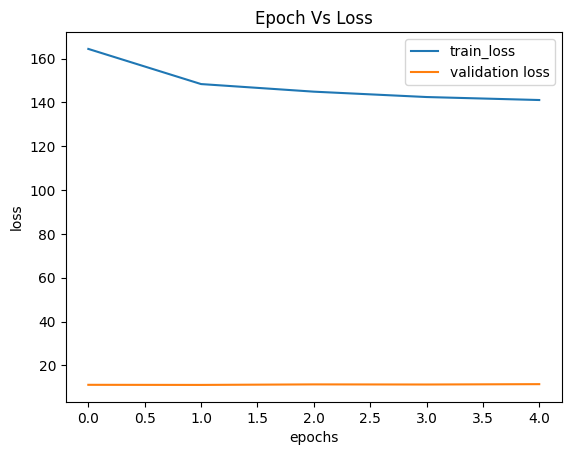

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(5)
plt.plot(x,train_losses,label = 'train_loss')
plt.plot(x,validation_losses,label = 'validation loss')
plt.legend()
plt.title("Epoch Vs Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

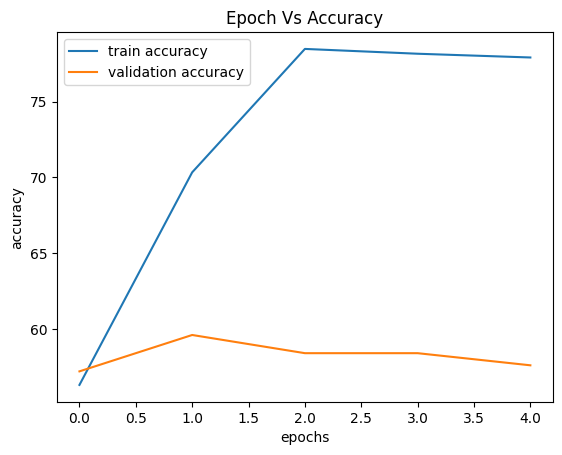

In [ ]:
x = np.arange(5)
plt.plot(x,train_accuracy,label = 'train accuracy')
plt.plot(x,val_accuracy,label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Epoch Vs Accuracy")
plt.show()

In [ ]:
test_accuracy=[]
losses =[]
predictions = []
real = []
model.eval()
with torch.no_grad():
  loss_test=0
  for batch_val in tqdm(test_loader):
    test_id = batch_val[0].to(device)
    test_am = batch_val[1].to(device)
    test_img = batch_val[2].to(device)
    test_label = batch_val[3].to(device)
    ots = model(test_img,test_id,test_am)
    loss = criterion(ots,test_label)
    loss_test+=loss.item()
    _,pred = ots.max(1)
    predictions.extend(pred.cpu().numpy())
    real.extend(test_label.cpu().numpy())
    correct = pred.eq(test_label).sum().item()
    total = test_label.size(0)
  acc = 100*(correct/total)
  test_accuracy.append(acc)
  losses.append(loss_test) 

100%|██████████| 32/32 [00:25<00:00,  1.28it/s]


In [57]:
test_accuracy=[]
losses =[]
predictions = []
real = []
model.eval()
with torch.no_grad():
  loss_test=0
  for batch_val in tqdm(test_loader):
    test_id = batch_val[0].to(device)
    test_am = batch_val[1].to(device)
    test_img = batch_val[2].to(device)
    test_label = batch_val[3].to(device)
    ots = model(test_img,test_id,test_am)
    loss = criterion(ots,test_label)
    loss_test+=loss.item()
    _,pred = ots.max(1)
    predictions.extend(pred.cpu().numpy())
    real.extend(test_label.cpu().numpy())
    correct = pred.eq(test_label).sum().item()
    total = test_label.size(0)
  acc = 100*(correct/total)
  test_accuracy.append(acc)
  losses.append(loss_test) 

100%|██████████| 32/32 [03:34<00:00,  6.70s/it]


In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [59]:
print("Precision score - ", precision_score(real,predictions))

Precision score -  0.6321243523316062


In [60]:
print("Recall score - ", recall_score(real,predictions))

Recall score -  0.49795918367346936


In [61]:
print("F1 score - ", f1_score(real,predictions))

F1 score -  0.5570776255707762


In [62]:
print("Accuracy score - ", accuracy_score(real,predictions))

Accuracy score -  0.612


In [63]:
print("Classification Report - \n", classification_report(real,predictions))

Classification Report - 
               precision    recall  f1-score   support

           0       0.60      0.72      0.65       510
           1       0.63      0.50      0.56       490

    accuracy                           0.61      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.62      0.61      0.61      1000



In [35]:
import pickle

# assume filename is the name of the pickle file
filename = '/content/sample_details.pkl'

# open the file in binary mode and read the data
with open(filename, 'rb') as f:
    data = pickle.load(f)

# print the loaded data
print(data)

       ID Label
0   01359     0
1   74029     0
2   18406     0
3   46503     0
4   64038     0
..    ...   ...
95  27496     1
96  47265     1
97  74813     1
98  38765     1
99  93251     1

[100 rows x 2 columns]


In [36]:
sample_text_ids = []
for i in range(len(data)):
  x = int(data['ID'][i])
  sample_text_ids.append(x)

sample_data_text_0 = []
sample_data_label_0 = []
sample_image_path_0 = []
sample_data_text_1 = []
sample_data_label_1 = []
sample_image_path_1 = []
for i in range(len(test['id'])):
  if(test['id'][i] in sample_text_ids ):
    if(test['label'][i]==0):
      sample_data_text_0.append(test['text'][i])
      sample_data_label_0.append(test['label'][i])
      sample_image_path_0.append(test['img'][i])
    elif(test['label'][i]==1):
      sample_data_text_1.append(test['text'][i])
      sample_data_label_1.append(test['label'][i])
      sample_image_path_1.append(test['img'][i])

In [37]:
sample_dataset_0 = Custom_Dataset(sample_image_path_0,sample_data_text_0,sample_data_label_0, transforms=train_transforms)
sample_loader_0 = DataLoader(sample_dataset_0, batch_size=len(sample_image_path_0), shuffle=False)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [38]:
sample_dataset_1 = Custom_Dataset(sample_image_path_1,sample_data_text_1,sample_data_label_1, transforms=train_transforms)
sample_loader_1 = DataLoader(sample_dataset_1, batch_size=len(sample_image_path_1), shuffle=False)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [41]:
batch_0 = next(iter(sample_loader_0))
batch_1 = next(iter(sample_loader_1))

In [42]:
test_id_0 = batch_0[0].to(device)
test_am_0 = batch_0[1].to(device)
test_img_0 = batch_0[2].to(device)
labels_0 = batch_0[3].to(device)
ots = model(test_img_0,test_id_0,test_am_0)

In [43]:
test_id_1 = batch_1[0].to(device)
test_am_1 = batch_1[1].to(device)
test_img_1 = batch_1[2].to(device)
labels_1 = batch_1[3].to(device)
ots = model(test_img_1,test_id_1,test_am_1)

In [ ]:
len(labels)

100

In [44]:
features_0 = model.get_features(test_img_0, test_id_0, test_am_0)
features_1 = model.get_features(test_img_1, test_id_1, test_am_1)

In [45]:
F_0 = features_0.cpu()
labels_0 = labels_0.cpu()

In [46]:
F_1 = features_1.cpu()
labels_1 = labels_1.cpu()

In [47]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
embeddings_0 = tsne.fit_transform(F_0)
embeddings_1 = tsne.fit_transform(F_1)

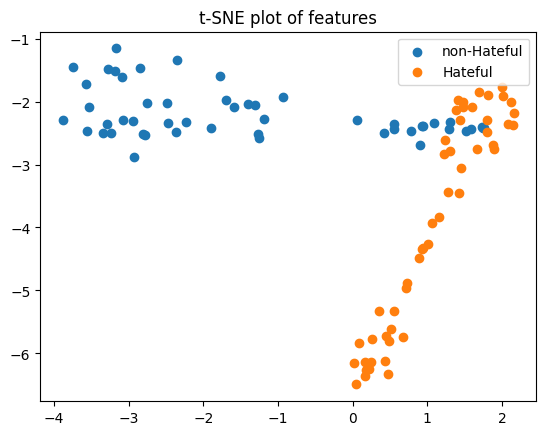

In [48]:
plt.scatter(embeddings_0[:,0], embeddings_0[:, 1], label='non-Hateful')
plt.scatter(embeddings_1[:, 0], embeddings_1[:, 1], label='Hateful')
plt.title('t-SNE plot of features')
plt.legend()
plt.show()

In [50]:
model

Multimodal(
  (image_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [51]:
torch.save(model.state_dict(), "/content/drive/MyDrive/multimodel.pt")

In [52]:
model.load_state_dict(torch.load('/content/drive/MyDrive/multimodel.pt'))

<All keys matched successfully>